# Homework 3 - Credit Analytics
Submission by Dennis Goldenberg

In [275]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime as dt
import statsmodels.api as stats
import scipy as sc
from PyCurve.curve import Curve
from PyCurve.linear import LinearCurve
from PyCurve.vasicek import Vasicek
from PyCurve.cubic import CubicCurve

## $\underline{\text{Question 1}}$

### a. Examining volatility and correlation structure of yield curves
I read the yield curve in and generate the daily percent change Matrix:

In [193]:
ticker = ['DGS1MO',  'DGS3MO', 'DGS6MO','DGS1','DGS2',
           'DGS3', 'DGS5','DGS7', 'DGS10','DGS20','DGS30']
sdt = dt.datetime(2003, 4, 10)
edt = dt.datetime(2024, 4, 12)
source = 'fred'
yieldcurve = pd.DataFrame(web.DataReader(ticker, source, sdt, edt))
yieldcurve = yieldcurve.dropna()
pctChange = yieldcurve.pct_change().dropna()
pctChange

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2003-04-11,0.000000,0.026316,0.025862,0.040000,0.031250,0.029557,0.020761,0.008671,0.012658,0.004049,0.003868
2003-04-14,0.008475,0.025641,0.025210,0.023077,0.054545,0.038278,0.023729,0.017192,0.010000,0.006048,0.001927
2003-04-15,-0.016807,-0.016667,-0.008197,-0.007519,-0.028736,-0.023041,-0.019868,-0.016901,-0.014851,-0.012024,-0.001923
2003-04-16,-0.017094,-0.008475,-0.008264,-0.007576,-0.011834,-0.009434,-0.003378,-0.002865,-0.005025,-0.002028,-0.011561
2003-04-17,-0.008696,0.008547,0.000000,0.022901,0.023952,0.023810,0.013559,0.005747,0.005051,-0.002033,-0.001949
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08,0.001828,0.000000,0.001873,0.003960,0.010571,0.013216,0.011416,0.009112,0.006834,0.000000,0.002203
2024-04-09,0.000000,0.000000,-0.001869,-0.007890,-0.008368,-0.017391,-0.013544,-0.011287,-0.013575,-0.010753,-0.010989
2024-04-10,0.001825,0.003683,0.011236,0.031809,0.048523,0.055310,0.054920,0.047945,0.043578,0.034783,0.031111


One slight issue is that, for maturities of 1 and 3 months, there are cases where the yield is 0, meaning the next day's percentage change would be infinity. I generate the percent change matrix with these rows excluded to get sensible results:

In [194]:
mask1MO = ((pctChange["DGS1MO"] > 5000000) | (pctChange["DGS1MO"] < -5000000)).values
mask3MO = ((pctChange["DGS3MO"] > 5000000) | (pctChange["DGS3MO"] < -5000000)).values
mask = mask1MO | mask3MO
pCNoInf = pctChange[~(mask)]

I examine both the means and standard deviations of the percent changes of the individual maturities, as well as the entire variance-covariance matrix:

In [195]:
meansSD = np.vstack([pCNoInf.mean(), pCNoInf.std()])
meanSDChange = pd.DataFrame(meansSD.T, index = pCNoInf.columns,
                            columns = ["Average % change","Standard Deviation"])
meanSDChange

,Average % change,Standard Deviation
DGS1MO,0.026158,0.340872
DGS3MO,0.017462,0.257891
DGS6MO,0.004202,0.106679
DGS1,0.001606,0.052359
DGS2,0.001430,0.049132
DGS3,0.001128,0.043144
DGS5,0.000772,0.035398
DGS7,0.000531,0.029100
DGS10,0.000404,0.025359
DGS20,0.000229,0.019901


In [196]:
pCNoInf.corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.286878,0.193646,0.145987,0.046646,0.045687,0.026228,0.019494,0.016355,0.022283,0.022453
DGS3MO,0.286878,1.000000,0.354084,0.186802,0.097015,0.083245,0.066044,0.056486,0.054324,0.050522,0.052292
DGS6MO,0.193646,0.354084,1.000000,0.285864,0.145925,0.141137,0.124743,0.109274,0.116982,0.120393,0.121919
DGS1,0.145987,0.186802,0.285864,1.000000,0.457498,0.451116,0.407459,0.385460,0.354379,0.320490,0.306785
DGS2,0.046646,0.097015,0.145925,0.457498,1.000000,0.807512,0.761878,0.701889,0.630252,0.547696,0.507569
DGS3,0.045687,0.083245,0.141137,0.451116,0.807512,1.000000,0.914180,0.859412,0.790411,0.704861,0.656183
DGS5,0.026228,0.066044,0.124743,0.407459,0.761878,0.914180,1.000000,0.959265,0.906666,0.828138,0.781184
DGS7,0.019494,0.056486,0.109274,0.385460,0.701889,0.859412,0.959265,1.000000,0.962750,0.903309,0.864201
DGS10,0.016355,0.054324,0.116982,0.354379,0.630252,0.790411,0.906666,0.962750,1.000000,0.957605,0.929271
DGS20,0.022283,0.050522,0.120393,0.320490,0.547696,0.704861,0.828138,0.903309,0.957605,1.000000,0.972052


I make 3 observations from these two results:
- The average percent change and standard deviation of percent change is $\textbf{higher}$ for shorter maturities, and $\textbf{lower}$ for longer maturities. This suggests that treasury rates with shorter maturities are more volatile than treasuries with longer maturities.
- All entries in the correlation matrix are positive. This suggests that there is a common market factor moving yields of all maturities in one direction or the other.
- For any given maturity length, the change in yield of that maturity length is generally more correlated with changes in yields of similar maturity lengths. For example, change in yield of Treasury securities with a maturity of 30 years is most correlated with the change in securities with maturities of 10 and 20 years.

### b. Estimating $\alpha, \beta, \sigma$ in simple short rate model

The model $dr = \alpha(\beta - r)dt + \sigma dW_t$ is a Vasicek model. This Model is an Ornstein-Uhlenback stochastic process. Therefore, it is true that ($\textit{Franco}$, 2023):
$$
R_t \sim N\left(\beta + (r_0 - \beta)e^{-\alpha t}, \frac{\sigma^2}{2\alpha}\left(1 - e^{-2\alpha t}\right)\right)
$$
Here, $t$ is in years. To estimate the parameters, I will use the one-month yield for each day in the downloaded yield curve. Since the first date observes is April 10th, 2003, and the 1-month yield is $1.18\%$, this will serve as $r_0$. Let $\Theta = \begin{bmatrix} \alpha & \beta & \sigma\end{bmatrix}$ be the parameters we are estimating. Let $\overrightarrow{r}$ be the sample of all short rates we obtain from the one month yield. Note that, via properties of a wiener process, $R_t|r_{t - 1} \sim N\left(\beta + (x_{t - 1} - \beta)e^{-\alpha \Delta_t}, \frac{\sigma^2}{2\alpha}\left(1 - e^{-2\alpha \Delta_t}\right)\right)$. Therefore, the likelihood function is:
$$
\begin{align*}
L\left(\overrightarrow{r};\Theta\right) &= \prod_{i = 1}^{N}\frac{1}{\sqrt{2\pi * \frac{\sigma^2}{2\alpha}\left(1 - e^{-2\alpha \Delta_{t_i}}\right)}} * e^{-\frac{\left(r_i - \left(\beta + (r_{i - 1} - \beta)e^{-\alpha \Delta_{t_i}}\right)\right)^2}{\frac{\sigma^2}{\alpha}\left(1 - e^{-2\alpha \Delta_{t_i}}\right)}}\\
&= \left(\frac{\sigma^2}{2\alpha}\right)^{-\frac{N}{2}} * \prod_{i = 1}^{n}\left(1 - e^{-2\alpha \Delta_{t_i}}\right)^{-\frac{1}{2}} * e^{-\frac{\alpha}{\sigma^2}\sum_{i = 1}^{N}\frac{\left(r_i - \left(\beta + (r_{i - 1} - \beta)e^{-\alpha \Delta_{t_i}}\right)\right)^2}{\left(1 - e^{-2\alpha \Delta_{t_i}}\right)}}
\end{align*}
$$
Therefore, the log-likelihood function is:
$$
\ell(\overrightarrow{r}|\Theta) = \frac{-N}{2}\ln \left(\frac{\sigma^2}{2\alpha}\right) -\frac{1}{2}\sum_{i = 1}^{n}\ln \left(1 - e^{-2\alpha \Delta t_i}\right) -\frac{\alpha}{\sigma^2}\sum_{i = 1}^{N}\frac{\left(r_{t_i} - \beta - \left(r_{t_{i - 1}} - \beta\right)e^{-\alpha \Delta t_i}\right)^2}{1 - e^{-2\alpha \Delta t_i}}
$$
Maximizing the likelihood function is equivalent to maximizing the log-likelihood function, which itself is equivalent to minimizing the negative log likelihood function. For the original maximization to proceed, it must be true that the following conditions are satisfied (and their result):
$$
\begin{align*}
&\frac{d\ell(\Theta|\overrightarrow{r})}{d\beta} = 0 \rightarrow \beta = \sum_{i = 1}^{N}\left(\frac{r_{t_i} - r_{t_{i - 1}}e^{-\alpha \Delta_{t_i}}}{1 + e^{-\alpha \Delta_{t_i}}}\right)*\left(\sum_{i = 1}^{n}\frac{1 - e^{-\alpha * \Delta_{t_i}}}{1 + e^{-\alpha * \Delta_{t_i}}}\right)^{-1}\\
&\frac{d\ell(\Theta|\overrightarrow{r})}{d\sigma^2} = 0 \rightarrow \sigma^2 = \frac{2\alpha}{n}\sum_{i = 1}^{n}\frac{\left(r_i - \beta - (r_{t_{i - 1}} - \beta)e^{-\alpha * \Delta_{t_i}}
\right)^2}{1 - e^{-2\alpha \Delta_{t_i}}}
\end{align*}
$$
Therefore, my process will be to optimize specifically for $\alpha$, and then get the implied $\beta$ and $\sigma^2$ values. First, I examine the plot of short rates over time:

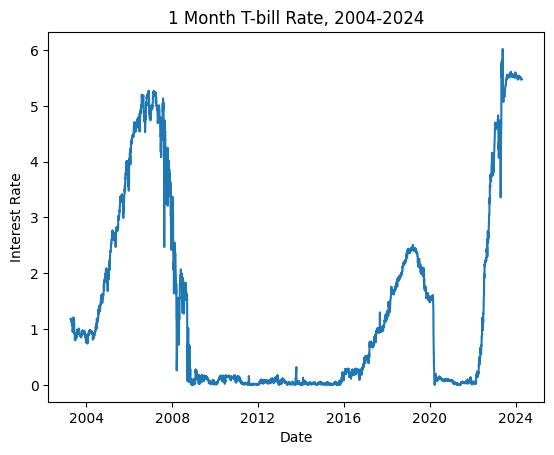

In [197]:
r_now = yieldcurve["DGS1MO"].values[1:]
plt.plot(yieldcurve.index[1:], r_now)
plt.title("1 Month T-bill Rate, 2004-2024")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.show()

Two things should be considered regarding the accuaracy of the estimates long-term:
- According to YCharts, the long-term average for Treasury bills of 1 Month maturity is about 1.44\% (So our estimate of $\beta$ should be around this value). Over this time period, the 1 month rate does not spend much time around that value.
- The practically zero-interest-rate environment of 2008-2016, great recession of 2008, and current interest rate spikes, are particularly anomolous over the economy's history.

With this in mind, I create the negative log likelihood function and check where it reaches its minimum:

In [198]:
def scalarNegLogLike(alpha):
    #read in time changes, rates, number of observations
    delta_t = (yieldcurve.index[1:] - yieldcurve.index[0:len(yieldcurve.index) - 1]).days.values/365
    r_now = yieldcurve["DGS1MO"].values[1:]
    r_before = yieldcurve["DGS1MO"].values[0:len(yieldcurve["DGS1MO"]) - 1]
    
    N = len(yieldcurve["DGS1MO"].values) - 1

    #calculate beta given alpha
    beta_1 = np.sum((r_now - (r_before * np.exp(-1 * alpha * delta_t)))/(1 + np.exp(-1 * alpha * delta_t)))
    beta_2 = 1/np.sum((1 - np.exp(-1 * alpha * delta_t))/(1 + np.exp(-1 * alpha * delta_t)))
    beta = beta_1 * beta_2

    #calculate sigmasq, given alpha
    sigmasq = np.square(r_now - beta - (r_before - beta)*np.exp(-1 * alpha * delta_t))
    sigmasq = sigmasq/(1 - np.exp(-2 * alpha * delta_t))
    sigmasq = ((2 * alpha)/N)*np.sum(sigmasq)
    term_1 = (N/2)*np.log(sigmasq/(2 * alpha))
    term_2 = (1/2)*np.sum(np.log((1 - np.exp(-2 * alpha * delta_t))))
    term_3 = (alpha/sigmasq) * np.square(r_now - beta - (r_before - beta) * np.exp(-1 * alpha * delta_t))
    term_3 = term_3/(1 - np.exp(-2 * alpha * delta_t))
    term_3 = np.sum(term_3)
    nll = term_1 + term_2 + term_3
    return nll

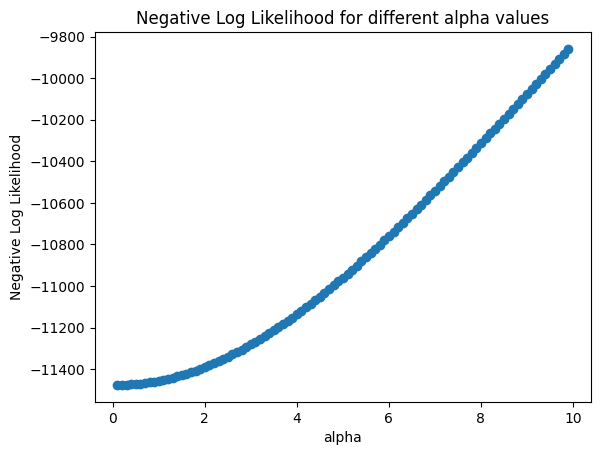

In [199]:
points = np.array([x * .1 for x in range(1,100)])
resp = []
for i in points:
    resp.append(scalarNegLogLike(i))
plt.scatter(points, resp)
plt.xlabel("alpha")
plt.ylabel("Negative Log Likelihood")
plt.title("Negative Log Likelihood for different alpha values")
plt.show()

As predicted, the negative log likelihood is minimized at a lower $\alpha$. However, the rate of decrease tends to flatline. I optimize the function, with a tolerance parameter, and then recover $\beta$ and $\sigma^2$:

In [350]:
#Get alpha
z = sc.optimize.minimize_scalar(fun = scalarNegLogLike, method = "bounded", bounds = (0,10), tol = 1)
alpha = z.x

#Get beta
delta_t = (yieldcurve.index[1:] - yieldcurve.index[0:len(yieldcurve.index) - 1]).days.values/365
r_now = yieldcurve["DGS1MO"].values[1:]
r_before = yieldcurve["DGS1MO"].values[0:len(yieldcurve["DGS1MO"]) - 1]
N = len(yieldcurve["DGS1MO"].values) - 1

beta_1 = np.sum((r_now - (r_before * np.exp(-1 * alpha * delta_t)))/(1 + np.exp(-1 * alpha * delta_t)))
beta_2 = 1/np.sum((1 - np.exp(-1 * alpha * delta_t))/(1 + np.exp(-1 * alpha * delta_t)))
beta = beta_1 * beta_2

#Get sigmasq
sigmasq = np.square(r_now - beta - (r_before - beta)*np.exp(-1 * alpha * delta_t))
sigmasq = sigmasq/(1 - np.exp(-2 * alpha * delta_t))
sigmasq = ((2 * alpha)/N)*np.sum(sigmasq)
alpha, beta, sigmasq

(0.5572809000084122, 1.777780050681752, 1.338624053374775)

So $\hat{\Theta} = \begin{bmatrix} 0.55728 & 1.77778 & 1.33862 \end{bmatrix}$.

### c. Calculating spread between points with one month yield

Using the April 12th, 2024 data, I find $r_0$ as the current 1 month rate:

In [201]:
x = yieldcurve.loc["2024-04-12"]
print("r_0:", x[0])

r_0: 5.48


Using the value as $r_0 = 5.48\%$, I calculate the spread at each point by subtracting the current short rate (1 month yield) from all other points in the curve:

In [202]:
spread = pd.DataFrame(data = (x - x[0]))
spread.columns = ["Spread"]
spread

,Spread
DGS1MO,0.00
DGS3MO,-0.03
DGS6MO,-0.12
DGS1,-0.35
DGS2,-0.60
DGS3,-0.78
DGS5,-0.94
DGS7,-0.95
DGS10,-0.98
DGS20,-0.75


Since the current short rate is so much higher than long-term yields, it makes sense for the yield curve to be inverted.

### d. Monte Carlo Simulation Engine

Note once again that:
$$
R_t \sim N\left(\beta + (r_0 - \beta)e^{-\alpha t}, \frac{\sigma^2}{2\alpha}\left(1 - e^{-2\alpha t}\right)\right)
$$
In order to generate a simulation, then, I have to simulate short rates at many points, and then synthesize the yield curve from that. I run 1000 simulations, with each simulation getting a daily short rate (Note that in each simulation, the current mean has to be updated to the instatiation of the previous mean, and assuming a 360 day year for simplicity later on):

In [378]:
np.random.seed(1)
times = np.asarray([i/360 for i in range(1, 360 * 5 + 1)])
delta_t = 1/360
currmean = beta + (x[0] - beta)*np.exp(-1 * alpha * delta_t)
std = np.sqrt((sigmasq/(2 * alpha))*(1 - np.exp(-2 * alpha * delta_t)))
num_sim = 1000
simulations = np.empty(shape = (num_sim, len(times)))
for i in range(num_sim):
    currmean = beta + (x[0] - beta)*np.exp(-1 * alpha * delta_t)
    for j in range(len(times)):
        simulations[i,j] = np.random.normal(loc = currmean, scale = std)
        currmean = beta + (simulations[i,j] - beta)*np.exp(-1 * alpha * delta_t)
simulations

array([[5.57324722, 5.53010112, 5.49211471, ..., 3.40731309, 3.45134673,
        3.55156507],
       [5.39457671, 5.47869757, 5.47753529, ..., 0.32449122, 0.26037944,
        0.34072244],
       [5.46825221, 5.44608318, 5.5467387 , ..., 3.16950206, 3.17200704,
        3.14471639],
       ...,
       [5.37746218, 5.34545007, 5.3305753 , ..., 2.01466613, 2.09764598,
        2.02362716],
       [5.32824561, 5.25953936, 5.23728351, ..., 2.78515159, 2.87685909,
        2.86999944],
       [5.41366433, 5.44690735, 5.4534751 , ..., 1.67533593, 1.73848919,
        1.77619248]])

Note that the discount factor for a zero-coupon bond is equal to $e^{-\int_t^{T}r_sds}$. I approxmiate this with a riemann sum with the area of each rectangle being 1/360 times the rate at the given moment:
$$
-\int_t^{T}r_sds \approx -\frac{1}{360}\sum_{i = t}^{T}r_i
$$

In [381]:
short_rates = simulations/100
integral_approx = -1 * (1/360) * short_rates
exp_disc_factor = np.cumsum(integral_approx, axis = 1)
disc_factors = np.exp(exp_disc_factor)
disc_factors

array([[0.9998452 , 0.99969162, 0.99953912, ..., 0.81601602, 0.81593779,
        0.8158573 ],
       [0.99985016, 0.99969801, 0.99954591, ..., 0.86761525, 0.86760898,
        0.86760077],
       [0.99984812, 0.99969687, 0.99954285, ..., 0.8055124 , 0.80544143,
        0.80537108],
       ...,
       [0.99985064, 0.99970219, 0.99955417, ..., 0.86419489, 0.86414454,
        0.86409596],
       [0.999852  , 0.99970594, 0.99956051, ..., 0.83086914, 0.83080275,
        0.83073652],
       [0.99984963, 0.99969836, 0.99954693, ..., 0.8406601 , 0.8406195 ,
        0.84057803]])

Given these discount factors, I can generate the yield curve:

### e. Pricing Interest Rate Swap

To price the interest rate swap today, I have to sum the expected discounted cash flows, given the yield curve on April 12th, 2024. I use the "PyCurve" package to perform linear interpolation to build out the yield curve, calculate the discount factors and forward rates:

In [371]:
Notional = 10000000
t = np.array([0,0.25, 0.5, 1,2,3,5,7,10,20,30])
rate = x[:].values
curve = Curve(t, rate)
linear_curve = CubicCurve(curve)
discount_factors = np.asarray([linear_curve.df_t(t_i/4) for t_i in (range(1,21))])
forward_rates = np.asarray([linear_curve.forward(t_i/4,(t_i + 1)/4) for t_i in range(0,20)])
variable_leg = np.round(forward_rates/100 * Notional,2)

Then, I create a dataframe showing the times, cash flows for fixed and variable legs, and the discount factor:

In [372]:
times = np.asarray([t_i/4 for t_i in range(1,21)])
fixed_leg = np.asarray([Notional] * 20) * .045
summary = pd.DataFrame(np.transpose(np.vstack((times, fixed_leg, variable_leg, discount_factors))))
summary.columns = ["Time (in years)", "Fixed Leg", "Variable Leg", "Discount Factor"]
summary

,Time (in years),Fixed Leg,Variable Leg,Discount Factor
0,0.25,450000.0,545000.00,0.986821
1,0.50,450000.0,527000.00,0.974231
2,0.75,450000.0,501053.77,0.962395
3,1.00,450000.0,478946.23,0.951203
4,1.25,450000.0,468872.48,0.940367
5,1.50,450000.0,464944.58,0.929743
6,1.75,450000.0,461891.33,0.919305
7,2.00,450000.0,456291.61,0.909106
8,2.25,450000.0,446335.64,0.899234
9,2.50,450000.0,436479.84,0.889679


Then I sum the present values and calculate the difference:

In [375]:
fixed_PV = np.sum(.045 * Notional * discount_factors)
variable_PV = np.sum(variable_leg * discount_factors)
fixed_PV - variable_PV

-103457.26536739897

Thus, as of this moment, this interest rate swap is worth $-\$103,457.27$ to me - not a good investment!

### f. Simulated Yield Curves Swap Price calculation

I know that the fixed leg in any simulation only various based on the discount factors calculated for each simulation at each quarter mark for the year:

In [368]:
fixed_for_sim = .045 * Notional * disc_factors[:,[(pmt * 90)  - 1 for pmt in range(1,21)]]
fixed_for_sim = np.sum(fixed_for_sim, axis = 1)

For the variable curve, I need to generate the yield curves, and generate the implied forward rates

## $\underline{\text{Sources}}$
Franco, J. C. G. (2023, May 14). Maximum likelihood estimation of a mean reverting process. investmentscience.com. http://www.investmentscience.com/Content/howtoArticles/MLE_for_OR_mean_reverting.pdf 

1 month Treasury Rate (I:1MTCMR). YCharts. (n.d.). https://ycharts.com/indicators/1_month_treasury_rate#:~:text=Basic%20Info,a%20maturity%20of%201%20month.

## Attempt at Optimization over multiple parameters

In [ ]:
def negLogLike(Theta):
    alpha, beta, sigmasq = Theta[0], Theta[1], Theta[2]
    N = len(yieldcurve["DGS1MO"].values) - 1
    delta_t = (yieldcurve.index[1:] - yieldcurve.index[0:len(yieldcurve.index) - 1]).days.values
    r_now = yieldcurve["DGS1MO"].values[1:]
    r_before = yieldcurve["DGS1MO"].values[0:len(yieldcurve["DGS1MO"]) - 1]
    term_1 = (N/2)*np.log(sigmasq/(2 * alpha))
    term_2 = (1/2)*np.sum(np.log((1 - np.exp(-2 * alpha * delta_t))))
    term_3 = (alpha/sigmasq) * np.square(r_now - beta - (r_before - beta) * np.exp(-1 * alpha * delta_t))
    term_3 = term_3/(1 - np.exp(-2 * alpha * delta_t))
    term_3 = np.sum(term_3)
    nll = term_1 + term_2 + term_3
    return nll


def negLogLike2(Theta):
    alpha, beta, sigmasq = Theta[0], Theta[1], Theta[2]
    N = len(yieldcurve["DGS1MO"].values) - 1
    delta_t = (yieldcurve.index[1:] - yieldcurve.index[0:len(yieldcurve.index) - 1]).days.values
    r_now = yieldcurve["DGS1MO"].values[1:]
    r_before = yieldcurve["DGS1MO"].values[0:len(yieldcurve["DGS1MO"]) - 1]
    return (N/2)*np.log(sigmasq/(2 * alpha)) + (1/2)*np.sum(np.log((1 - np.exp(-2 * alpha * delta_t)))) + (alpha/sigmasq)*np.sum((np.square(r_now - beta - (r_before - beta) * np.exp(-1 * alpha * delta_t))/(1 - np.exp(-2 * alpha * delta_t))))

In [ ]:
init_guess = np.array([5,np.mean(yieldcurve["DGS1MO"].values),np.var(yieldcurve["DGS1MO"].values)])
y = sc.optimize.minimize(fun = negLogLike, x0 = init_guess,method = "L-BFGS-B",
   bounds = ((None, None), (0.05, None), (0.05, None)))
y